In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from moviepy.editor import VideoClip
from IPython.display import HTML

# Environment settings
GRID_SIZE = 4  # Small grid size for Q-learning

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 500

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(100):
            action = agent.act(state)
            alive = snake.move(action)
            reward = -10 if not alive else 0

            if snake.positions[0] == food.position:
                snake.grow()
                food.spawn()
                reward = 10  # Reward for eating food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 50 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(100):
        frames.append((np.copy(snake.positions), food.position))
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video(frames, size, duration=10):
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xticks(np.arange(-0.5, size, 1))
        ax.set_yticks(np.arange(-0.5, size, 1))
        ax.grid(which="both")
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        grid_display = np.zeros((size, size))
        grid_display[frames[0][1]] = 1  # Mark food
        current_frame_idx = min(int(t * len(frames) / duration), len(frames) - 1)
        for pos in frames[current_frame_idx][0]:
            grid_display[pos] = 0.5  # Mark snake's position
        ax.imshow(grid_display, cmap="gray", origin="upper", extent=[0, size, size, 0])

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    video = VideoClip(make_frame, duration=duration)
    video.write_videofile("snake_game_q_learning.mp4", fps=30)

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 10-second video of the learned path
create_video(frames, GRID_SIZE, duration=10)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_q_learning.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -10, Epsilon: 0.9801495006250001
Episode: 50, Total Reward: -10, Epsilon: 0.2457325055235537
Episode: 100, Total Reward: 0, Epsilon: 0.00998645168764533
Episode: 150, Total Reward: 10, Epsilon: 0.00998645168764533
Episode: 200, Total Reward: 20, Epsilon: 0.00998645168764533
Episode: 250, Total Reward: 10, Epsilon: 0.00998645168764533
Episode: 300, Total Reward: 0, Epsilon: 0.00998645168764533
Episode: 350, Total Reward: 0, Epsilon: 0.00998645168764533
Episode: 400, Total Reward: 20, Epsilon: 0.00998645168764533
Episode: 450, Total Reward: 10, Epsilon: 0.00998645168764533
Moviepy - Building video snake_game_q_learning.mp4.
Moviepy - Writing video snake_game_q_learning.mp4



Moviepy - Done !
Moviepy - video ready snake_game_q_learning.mp4


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Increase grid size for better visualization

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 500

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(100):
            action = agent.act(state)
            alive = snake.move(action)
            reward = -10 if not alive else 0

            if snake.positions[0] == food.position:
                snake.grow()
                food.spawn()
                reward = 10  # Reward for eating food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 50 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(100):
        frames.append((np.copy(snake.positions), food.position))
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video(frames, size, duration=10):
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        current_frame_idx = min(int(t * len(frames) / duration), len(frames) - 1)
        snake_positions, food_position = frames[current_frame_idx]

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    video = VideoClip(make_frame, duration=duration)
    video.write_videofile("snake_game_better_graphics.mp4", fps=10)

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 10-second video of the learned path
create_video(frames, GRID_SIZE, duration=10)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_better_graphics.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: 0, Epsilon: 0.9801495006250001
Episode: 50, Total Reward: -10, Epsilon: 0.10376060541355137
Episode: 100, Total Reward: 0, Epsilon: 0.017420043796269234
Episode: 150, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 200, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 250, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 300, Total Reward: 0, Epsilon: 0.00998645168764533
Episode: 350, Total Reward: 0, Epsilon: 0.00998645168764533
Episode: 400, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 450, Total Reward: -10, Epsilon: 0.00998645168764533
Moviepy - Building video snake_game_better_graphics.mp4.
Moviepy - Writing video snake_game_better_graphics.mp4



Moviepy - Done !
Moviepy - video ready snake_game_better_graphics.mp4


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Increase grid size for better visualization
MAX_SNAKE_LENGTH = 8  # Set a maximum length for the snake

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 500

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(100):
            action = agent.act(state)
            alive = snake.move(action)
            reward = -10 if not alive else 0

            if snake.positions[0] == food.position:
                snake.grow()
                food.spawn()
                reward = 10  # Reward for eating food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 50 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(100):
        frames.append((np.copy(snake.positions), food.position))
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video(frames, size, duration=10):
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        current_frame_idx = min(int(t * len(frames) / duration), len(frames) - 1)
        snake_positions, food_position = frames[current_frame_idx]

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    video = VideoClip(make_frame, duration=duration)
    video.write_videofile("snake_game_better_graphics.mp4", fps=10)

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 10-second video of the learned path
create_video(frames, GRID_SIZE, duration=10)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_better_graphics.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -10, Epsilon: 0.8603841919146962
Episode: 50, Total Reward: -10, Epsilon: 0.08035439121179945
Episode: 100, Total Reward: -10, Epsilon: 0.014471156162198668
Episode: 150, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 200, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 250, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 300, Total Reward: 0, Epsilon: 0.00998645168764533
Episode: 350, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 400, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 450, Total Reward: -10, Epsilon: 0.00998645168764533
Moviepy - Building video snake_game_better_graphics.mp4.
Moviepy - Writing video snake_game_better_graphics.mp4



Moviepy - Done !
Moviepy - video ready snake_game_better_graphics.mp4


In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Increase grid size for better visualization
MAX_SNAKE_LENGTH = 8  # Set a maximum length for the snake

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 1000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(200):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 10  # Reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 50 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(100):
        frames.append((np.copy(snake.positions), food.position))
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video(frames, size, duration=10):
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        current_frame_idx = min(int(t * len(frames) / duration), len(frames) - 1)
        snake_positions, food_position = frames[current_frame_idx]

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    video = VideoClip(make_frame, duration=duration)
    video.write_videofile("snake_game_better_graphics.mp4", fps=10)

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 10-second video of the learned path
create_video(frames, GRID_SIZE, duration=10)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_better_graphics.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -14, Epsilon: 0.918316468354365
Episode: 50, Total Reward: -13, Epsilon: 0.07018314008827135
Episode: 100, Total Reward: -14, Epsilon: 0.010137759008060509
Episode: 150, Total Reward: -19, Epsilon: 0.00998645168764533
Episode: 200, Total Reward: 13, Epsilon: 0.00998645168764533
Episode: 250, Total Reward: -16, Epsilon: 0.00998645168764533
Episode: 300, Total Reward: -14, Epsilon: 0.00998645168764533
Episode: 350, Total Reward: -18, Epsilon: 0.00998645168764533
Episode: 400, Total Reward: -1, Epsilon: 0.00998645168764533
Episode: 450, Total Reward: 1, Epsilon: 0.00998645168764533
Episode: 500, Total Reward: -1, Epsilon: 0.00998645168764533
Episode: 550, Total Reward: -17, Epsilon: 0.00998645168764533
Episode: 600, Total Reward: 16, Epsilon: 0.00998645168764533
Episode: 650, Total Reward: 2, Epsilon: 0.00998645168764533
Episode: 700, Total Reward: -3, Epsilon: 0.00998645168764533
Episode: 750, Total Reward: 2, Epsilon: 0.00998645168764533
Episode: 800, Total Rew

Moviepy - Done !
Moviepy - video ready snake_game_better_graphics.mp4


In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Increase grid size for better visualization
MAX_SNAKE_LENGTH = 10  # Set a maximum length for the snake

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 2000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(200):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 10  # Reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(200):  # Increase the number of steps in simulation
        frames.append((np.copy(snake.positions), food.position))
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video(frames, size, duration=20):  # Increase video duration to 20 seconds
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        current_frame_idx = min(int(t * len(frames) / duration), len(frames) - 1)
        snake_positions, food_position = frames[current_frame_idx]

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    video = VideoClip(make_frame, duration=duration)
    video.write_videofile("snake_game_better_graphics.mp4", fps=10)

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path
create_video(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_better_graphics.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -8, Epsilon: 0.9369146928798039
Episode: 100, Total Reward: -8, Epsilon: 0.010499784796482848
Episode: 200, Total Reward: 2, Epsilon: 0.00998645168764533
Episode: 300, Total Reward: -8, Epsilon: 0.00998645168764533
Episode: 400, Total Reward: -5, Epsilon: 0.00998645168764533
Episode: 500, Total Reward: -17, Epsilon: 0.00998645168764533
Episode: 600, Total Reward: 14, Epsilon: 0.00998645168764533
Episode: 700, Total Reward: 14, Epsilon: 0.00998645168764533
Episode: 800, Total Reward: 4, Epsilon: 0.00998645168764533
Episode: 900, Total Reward: -1, Epsilon: 0.00998645168764533
Episode: 1000, Total Reward: 5, Epsilon: 0.00998645168764533
Episode: 1100, Total Reward: 11, Epsilon: 0.00998645168764533
Episode: 1200, Total Reward: 2, Epsilon: 0.00998645168764533
Episode: 1300, Total Reward: 10, Epsilon: 0.00998645168764533
Episode: 1400, Total Reward: 45, Epsilon: 0.00998645168764533
Episode: 1500, Total Reward: 5, Epsilon: 0.00998645168764533
Episode: 1600, Total Rew

Moviepy - Done !
Moviepy - video ready snake_game_better_graphics.mp4


In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Increase grid size for better visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 3000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(200):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 10  # Reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(300):  # Increase the number of steps in simulation
        frames.append((np.copy(snake.positions), food.position))
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video(frames, size, duration=15):  # Keep video duration short but faster speed
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        current_frame_idx = min(int(t * len(frames) / duration), len(frames) - 1)
        snake_positions, food_position = frames[current_frame_idx]

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    video = VideoClip(make_frame, duration=duration)
    video.write_videofile("snake_game_better_graphics.mp4", fps=20)  # Speed up video by increasing fps

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 15-second video of the learned path
create_video(frames, GRID_SIZE, duration=15)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_better_graphics.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -33, Epsilon: 0.6180388156137953
Episode: 100, Total Reward: -15, Epsilon: 0.00998645168764533
Episode: 200, Total Reward: -15, Epsilon: 0.00998645168764533
Episode: 300, Total Reward: -10, Epsilon: 0.00998645168764533
Episode: 400, Total Reward: 6, Epsilon: 0.00998645168764533
Episode: 500, Total Reward: -17, Epsilon: 0.00998645168764533
Episode: 600, Total Reward: -5, Epsilon: 0.00998645168764533
Episode: 700, Total Reward: -9, Epsilon: 0.00998645168764533
Episode: 800, Total Reward: 4, Epsilon: 0.00998645168764533
Episode: 900, Total Reward: -4, Epsilon: 0.00998645168764533
Episode: 1000, Total Reward: -12, Epsilon: 0.00998645168764533
Episode: 1100, Total Reward: -7, Epsilon: 0.00998645168764533
Episode: 1200, Total Reward: 5, Epsilon: 0.00998645168764533
Episode: 1300, Total Reward: 5, Epsilon: 0.00998645168764533
Episode: 1400, Total Reward: 1, Epsilon: 0.00998645168764533
Episode: 1500, Total Reward: 15, Epsilon: 0.00998645168764533
Episode: 1600, Total

Moviepy - Done !
Moviepy - video ready snake_game_better_graphics.mp4


Episode: 0, Total Reward: -26, Epsilon: 0.8560822709551227
Episode: 500, Total Reward: -19, Epsilon: 0.00998645168764533
Episode: 1000, Total Reward: 2, Epsilon: 0.00998645168764533
Episode: 1500, Total Reward: 3, Epsilon: 0.00998645168764533
Episode: 2000, Total Reward: 11, Epsilon: 0.00998645168764533
Episode: 2500, Total Reward: -1, Epsilon: 0.00998645168764533
Episode: 3000, Total Reward: 18, Epsilon: 0.00998645168764533
Episode: 3500, Total Reward: 5, Epsilon: 0.00998645168764533
Episode: 4000, Total Reward: 15, Epsilon: 0.00998645168764533
Episode: 4500, Total Reward: 80, Epsilon: 0.00998645168764533


IndexError: list index out of range

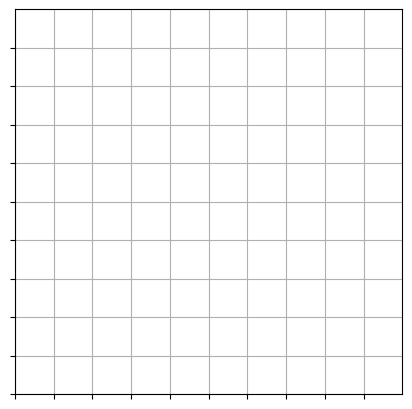

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip, concatenate_videoclips
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Grid size for visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake
MIN_SNAKE_LENGTH_FOR_VIDEO = 5  # Minimum length before capturing in video

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 5000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(200):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 10  # Reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 500 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(500):  # Increase the number of steps in simulation
        if snake.length >= MIN_SNAKE_LENGTH_FOR_VIDEO:
            frames.append((np.copy(snake.positions), food.position))  # Start capturing frames once snake is long enough
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video_with_title(frames, size, duration=20):  # Keep video duration to 20 seconds
    # Create the title frame
    def make_title_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.text(0.5, 0.5, 'Snake Game AI\nUsing Q-Learning', fontsize=24, ha='center', va='center', wrap=True)
        ax.set_axis_off()
        
        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create the gameplay frames
    def make_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        current_frame_idx = min(int(t * len(frames) / duration), len(frames) - 1)
        snake_positions, food_position = frames[current_frame_idx]

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create video clips
    title_clip = VideoClip(make_title_frame, duration=3)  # Title frame for 3 seconds
    game_clip = VideoClip(make_frame, duration=duration - 3)  # Rest of the video for gameplay

    # Concatenate title and gameplay clips
    final_clip = concatenate_videoclips([title_clip, game_clip])
    final_clip.write_videofile("snake_game_with_title.mp4", fps=30)  # Increase fps for faster video

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path with title
create_video_with_title(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_with_title.mp4" type="video/mp4">
</video>
""")


In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip, concatenate_videoclips
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Grid size for visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake
MIN_SNAKE_LENGTH_FOR_VIDEO = 5  # Minimum length before capturing in video

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 5000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(200):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 10  # Reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 500 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(500):  # Increase the number of steps in simulation
        if snake.length >= MIN_SNAKE_LENGTH_FOR_VIDEO:
            frames.append((np.copy(snake.positions), food.position))  # Start capturing frames once snake is long enough
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video_with_title(frames, size, duration=20):  # Keep video duration to 20 seconds
    # Create the title frame
    def make_title_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.text(0.5, 0.5, 'Snake Game AI\nUsing Q-Learning', fontsize=24, ha='center', va='center', wrap=True)
        ax.set_axis_off()
        
        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create the gameplay frames
    def make_frame(t):
        frame_count = len(frames)
        current_frame_idx = min(int(t * frame_count / (duration - 3)), frame_count - 1)  # Adjust frame selection
        snake_positions, food_position = frames[current_frame_idx]

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create video clips
    title_clip = VideoClip(make_title_frame, duration=3)  # Title frame for 3 seconds
    game_clip = VideoClip(make_frame, duration=duration - 3)  # Rest of the video for gameplay

    # Concatenate title and gameplay clips
    final_clip = concatenate_videoclips([title_clip, game_clip])
    final_clip.write_videofile("snake_game_with_title.mp4", fps=30)  # Increase fps for faster video

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path with title
create_video_with_title(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_with_title.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -12, Epsilon: 0.8475428503023453
Episode: 500, Total Reward: 6, Epsilon: 0.00998645168764533
Episode: 1000, Total Reward: -8, Epsilon: 0.00998645168764533
Episode: 1500, Total Reward: 18, Epsilon: 0.00998645168764533
Episode: 2000, Total Reward: 85, Epsilon: 0.00998645168764533
Episode: 2500, Total Reward: 3, Epsilon: 0.00998645168764533
Episode: 3000, Total Reward: 39, Epsilon: 0.00998645168764533
Episode: 3500, Total Reward: 92, Epsilon: 0.00998645168764533
Episode: 4000, Total Reward: 26, Epsilon: 0.00998645168764533
Episode: 4500, Total Reward: 3, Epsilon: 0.00998645168764533


IndexError: list index out of range

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip, concatenate_videoclips
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Grid size for visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake
MIN_SNAKE_LENGTH_FOR_VIDEO = 5  # Minimum length before capturing in video

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 5000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(200):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 10  # Reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 500 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(500):  # Increase the number of steps in simulation
        if snake.length >= MIN_SNAKE_LENGTH_FOR_VIDEO:
            frames.append((np.copy(snake.positions), food.position))  # Start capturing frames once snake is long enough
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video_with_title(frames, size, duration=20):  # Keep video duration to 20 seconds
    # Create the title frame
    def make_title_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.text(0.5, 0.5, 'Snake Game AI\nUsing Q-Learning', fontsize=24, ha='center', va='center', wrap=True)
        ax.set_axis_off()
        
        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create the gameplay frames
    def make_frame(t):
        frame_count = len(frames)
        if frame_count == 0:
            return make_title_frame(t)  # Show title if no frames are captured

        current_frame_idx = min(int(t * frame_count / (duration - 3)), frame_count - 1)  # Adjust frame selection
        snake_positions, food_position = frames[current_frame_idx]

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create video clips
    title_clip = VideoClip(make_title_frame, duration=3)  # Title frame for 3 seconds
    game_clip = VideoClip(make_frame, duration=duration - 3)  # Rest of the video for gameplay

    # Concatenate title and gameplay clips
    final_clip = concatenate_videoclips([title_clip, game_clip])
    final_clip.write_videofile("snake_game_with_title.mp4", fps=30)  # Increase fps for faster video

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path with title
create_video_with_title(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_with_title.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -10, Epsilon: 0.8822202429488013
Episode: 500, Total Reward: 4, Epsilon: 0.00998645168764533
Episode: 1000, Total Reward: 3, Epsilon: 0.00998645168764533
Episode: 1500, Total Reward: 2, Epsilon: 0.00998645168764533
Episode: 2000, Total Reward: 12, Epsilon: 0.00998645168764533
Episode: 2500, Total Reward: 8, Epsilon: 0.00998645168764533
Episode: 3000, Total Reward: 59, Epsilon: 0.00998645168764533
Episode: 3500, Total Reward: 17, Epsilon: 0.00998645168764533
Episode: 4000, Total Reward: 29, Epsilon: 0.00998645168764533
Episode: 4500, Total Reward: 17, Epsilon: 0.00998645168764533
Moviepy - Building video snake_game_with_title.mp4.
Moviepy - Writing video snake_game_with_title.mp4



Moviepy - Done !
Moviepy - video ready snake_game_with_title.mp4


In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip, concatenate_videoclips
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Grid size for visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 5000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(200):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 10  # Reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 500 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(500):  # Increase the number of steps in simulation
        frames.append((np.copy(snake.positions), food.position))  # Capture frames from the start
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video_with_title(frames, size, duration=20):  # Keep video duration to 20 seconds
    # Create the title frame
    def make_title_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.text(0.5, 0.5, 'Snake Game AI\nUsing Q-Learning', fontsize=24, ha='center', va='center', wrap=True)
        ax.set_axis_off()
        
        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create the gameplay frames
    def make_frame(t):
        frame_count = len(frames)
        if frame_count == 0:
            return make_title_frame(t)  # Show title if no frames are captured

        current_frame_idx = min(int(t * frame_count / (duration - 3)), frame_count - 1)  # Adjust frame selection
        snake_positions, food_position = frames[current_frame_idx]

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
            ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create video clips
    title_clip = VideoClip(make_title_frame, duration=3)  # Title frame for 3 seconds
    game_clip = VideoClip(make_frame, duration=duration - 3)  # Rest of the video for gameplay

    # Concatenate title and gameplay clips
    final_clip = concatenate_videoclips([title_clip, game_clip])
    final_clip.write_videofile("snake_game_with_title.mp4", fps=30)  # Increase fps for faster video

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path with title
create_video_with_title(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_with_title.mp4" type="video/mp4">
</video>
""")


IndentationError: unexpected indent (2775570277.py, line 191)

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip, concatenate_videoclips
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Grid size for visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 5000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(200):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 10  # Reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 500 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(500):  # Increase the number of steps in simulation
        frames.append((np.copy(snake.positions), food.position))  # Capture frames from the start
        action = agent.act(state)
        alive = snake.move(action)
        if not alive:
            break
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video_with_title(frames, size, duration=20):  # Keep video duration to 20 seconds
    # Create the title frame
    def make_title_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.text(0.5, 0.5, 'Snake Game AI\nUsing Q-Learning', fontsize=24, ha='center', va='center', wrap=True)
        ax.set_axis_off()
        
        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create the gameplay frames
    def make_frame(t):
        frame_count = len(frames)
        if frame_count == 0:
            return make_title_frame(t)  # Show title if no frames are captured

        current_frame_idx = min(int(t * frame_count / (duration - 3)), frame_count - 1)  # Adjust frame selection
        snake_positions, food_position = frames[current_frame_idx]

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create video clips
    title_clip = VideoClip(make_title_frame, duration=3)  # Title frame for 3 seconds
    game_clip = VideoClip(make_frame, duration=duration - 3)  # Rest of the video for gameplay

    # Concatenate title and gameplay clips
    final_clip = concatenate_videoclips([title_clip, game_clip])
    final_clip.write_videofile("snake_game_with_title.mp4", fps=30)  # Increase fps for faster video

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path with title
create_video_with_title(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_with_title.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -11, Epsilon: 0.9137248860125932
Episode: 500, Total Reward: 3, Epsilon: 0.00998645168764533
Episode: 1000, Total Reward: 5, Epsilon: 0.00998645168764533
Episode: 1500, Total Reward: 1, Epsilon: 0.00998645168764533
Episode: 2000, Total Reward: 51, Epsilon: 0.00998645168764533
Episode: 2500, Total Reward: 21, Epsilon: 0.00998645168764533
Episode: 3000, Total Reward: 40, Epsilon: 0.00998645168764533
Episode: 3500, Total Reward: 15, Epsilon: 0.00998645168764533
Episode: 4000, Total Reward: 14, Epsilon: 0.00998645168764533
Episode: 4500, Total Reward: 2, Epsilon: 0.00998645168764533
Moviepy - Building video snake_game_with_title.mp4.
Moviepy - Writing video snake_game_with_title.mp4



Moviepy - Done !
Moviepy - video ready snake_game_with_title.mp4


In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip, concatenate_videoclips
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Grid size for visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake
TARGET_SNAKE_LENGTH = 5  # Desired snake length for the video

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 6000  # Increase episodes to allow more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(300):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 20  # Increase reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 500 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(1000):  # Further increase the number of steps in simulation
        frames.append((np.copy(snake.positions), food.position))  # Capture frames from the start
        action = agent.act(state)
        alive = snake.move(action)
        if not alive or snake.length >= TARGET_SNAKE_LENGTH:
            break  # Stop if the snake dies or reaches the target length
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video_with_title(frames, size, duration=20):  # Keep video duration to 20 seconds
    # Create the title frame
    def make_title_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.text(0.5, 0.5, 'Snake Game AI\nUsing Q-Learning', fontsize=24, ha='center', va='center', wrap=True)
        ax.set_axis_off()
        
        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create the gameplay frames
    def make_frame(t):
        frame_count = len(frames)
        if frame_count == 0:
            return make_title_frame(t)  # Show title if no frames are captured

        current_frame_idx = min(int(t * frame_count / (duration - 3)), frame_count - 1)  # Adjust frame selection
        snake_positions, food_position = frames[current_frame_idx]

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create video clips
    title_clip = VideoClip(make_title_frame, duration=3)  # Title frame for 3 seconds
    game_clip = VideoClip(make_frame, duration=duration - 3)  # Rest of the video for gameplay

    # Concatenate title and gameplay clips
    final_clip = concatenate_videoclips([title_clip, game_clip])
    final_clip.write_videofile("snake_game_with_title.mp4", fps=30)  # Increase fps for faster video

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path with title
create_video_with_title(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_with_title.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -27, Epsilon: 0.7183288830986236
Episode: 500, Total Reward: 19, Epsilon: 0.00998645168764533
Episode: 1000, Total Reward: 29, Epsilon: 0.00998645168764533
Episode: 1500, Total Reward: 16, Epsilon: 0.00998645168764533
Episode: 2000, Total Reward: 61, Epsilon: 0.00998645168764533
Episode: 2500, Total Reward: 33, Epsilon: 0.00998645168764533
Episode: 3000, Total Reward: 43, Epsilon: 0.00998645168764533
Episode: 3500, Total Reward: 14, Epsilon: 0.00998645168764533
Episode: 4000, Total Reward: 13, Epsilon: 0.00998645168764533
Episode: 4500, Total Reward: 28, Epsilon: 0.00998645168764533
Episode: 5000, Total Reward: 134, Epsilon: 0.00998645168764533
Episode: 5500, Total Reward: 38, Epsilon: 0.00998645168764533
Moviepy - Building video snake_game_with_title.mp4.
Moviepy - Writing video snake_game_with_title.mp4



Moviepy - Done !
Moviepy - video ready snake_game_with_title.mp4


In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip, concatenate_videoclips
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Grid size for visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake
TARGET_SNAKE_LENGTH = 5  # Desired snake length for the video

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.997  # Slightly slower decay for more exploration

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 8000  # Further increase episodes for more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(400):  # Increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 20  # Increase reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 500 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(1500):  # Further increase the number of steps in simulation
        frames.append((np.copy(snake.positions), food.position))  # Capture frames from the start
        action = agent.act(state)
        alive = snake.move(action)
        if not alive or snake.length >= TARGET_SNAKE_LENGTH:
            break  # Stop if the snake dies or reaches the target length
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    return frames

def create_video_with_title(frames, size, duration=20):  # Keep video duration to 20 seconds
    # Create the title frame
    def make_title_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.text(0.5, 0.5, 'Snake Game AI\nUsing Q-Learning', fontsize=24, ha='center', va='center', wrap=True)
        ax.set_axis_off()
        
        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create the gameplay frames
    def make_frame(t):
        frame_count = len(frames)
        if frame_count == 0:
            return make_title_frame(t)  # Show title if no frames are captured

        current_frame_idx = min(int(t * frame_count / (duration - 3)), frame_count - 1)  # Adjust frame selection
        snake_positions, food_position = frames[current_frame_idx]

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create video clips
    title_clip = VideoClip(make_title_frame, duration=3)  # Title frame for 3 seconds
    game_clip = VideoClip(make_frame, duration=duration - 3)  # Rest of the video for gameplay

    # Concatenate title and gameplay clips
    final_clip = concatenate_videoclips([title_clip, game_clip])
    final_clip.write_videofile("snake_game_with_title.mp4", fps=30)  # Increase fps for faster video

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path with title
create_video_with_title(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_with_title.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: -15, Epsilon: 0.93603800616986
Episode: 500, Total Reward: -16, Epsilon: 0.00999258133189499
Episode: 1000, Total Reward: 11, Epsilon: 0.00999258133189499
Episode: 1500, Total Reward: 11, Epsilon: 0.00999258133189499
Episode: 2000, Total Reward: 5, Epsilon: 0.00999258133189499
Episode: 2500, Total Reward: 37, Epsilon: 0.00999258133189499
Episode: 3000, Total Reward: 93, Epsilon: 0.00999258133189499
Episode: 3500, Total Reward: 60, Epsilon: 0.00999258133189499
Episode: 4000, Total Reward: 106, Epsilon: 0.00999258133189499
Episode: 4500, Total Reward: 14, Epsilon: 0.00999258133189499
Episode: 5000, Total Reward: 10, Epsilon: 0.00999258133189499
Episode: 5500, Total Reward: 61, Epsilon: 0.00999258133189499
Episode: 6000, Total Reward: 57, Epsilon: 0.00999258133189499
Episode: 6500, Total Reward: 85, Epsilon: 0.00999258133189499
Episode: 7000, Total Reward: 40, Epsilon: 0.00999258133189499
Episode: 7500, Total Reward: 10, Epsilon: 0.00999258133189499
Moviepy - Bui

Moviepy - Done !
Moviepy - video ready snake_game_with_title.mp4


In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from moviepy.editor import VideoClip, concatenate_videoclips
from IPython.display import HTML

# Environment settings
GRID_SIZE = 10  # Grid size for visualization
MAX_SNAKE_LENGTH = 15  # Set a longer maximum length for the snake
TARGET_SNAKE_LENGTH = 5  # Desired snake length for the video

# Define the Snake and Food classes in a simple grid environment
class Snake:
    def __init__(self):
        self.reset()

    def reset(self):
        self.positions = [(GRID_SIZE // 2, GRID_SIZE // 2)]  # Start in the middle
        self.direction = (0, -1)  # Initially moving up
        self.length = 1

    def move(self, action):
        if action == 0:
            self.direction = (0, -1)  # Move up
        elif action == 1:
            self.direction = (1, 0)  # Move right
        elif action == 2:
            self.direction = (0, 1)  # Move down
        elif action == 3:
            self.direction = (-1, 0)  # Move left

        head_x, head_y = self.positions[0]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])

        # Check for wall collision or self-collision
        if new_head in self.positions or not (0 <= new_head[0] < GRID_SIZE) or not (0 <= new_head[1] < GRID_SIZE):
            return False  # Game over

        # Update positions
        self.positions = [new_head] + self.positions[:self.length - 1]
        return True

    def grow(self):
        if self.length < MAX_SNAKE_LENGTH:  # Grow only if below max length
            self.length += 1  # Increase length by 1

class Food:
    def __init__(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

    def spawn(self):
        self.position = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

# Q-learning Agent
class QLearningAgent:
    def __init__(self):
        self.state_size = (GRID_SIZE, GRID_SIZE, GRID_SIZE, GRID_SIZE)
        self.action_size = 4  # 4 possible actions: up, right, down, left
        self.q_table = np.zeros(self.state_size + (self.action_size,))
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999  # Much slower decay for longer exploration

    def get_state(self, snake, food):
        head_x, head_y = snake.positions[0]
        food_x, food_y = food.position
        return head_x, head_y, food_x, food_y

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state + (best_next_action,)]
        self.q_table[state + (action,)] += self.learning_rate * (td_target - self.q_table[state + (action,)])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Train the agent
def train_q_learning():
    agent = QLearningAgent()
    episodes = 12000  # Significantly increase episodes for more learning

    for episode in range(episodes):
        snake = Snake()
        food = Food()
        state = agent.get_state(snake, food)
        total_reward = 0

        for _ in range(500):  # Further increase steps per episode
            action = agent.act(state)
            alive = snake.move(action)

            # Calculate reward
            if not alive:
                reward = -10  # Strong negative reward for dying
            else:
                current_distance = np.abs(snake.positions[0][0] - food.position[0]) + np.abs(snake.positions[0][1] - food.position[1])
                next_distance = np.abs(snake.positions[0][0] + snake.direction[0] - food.position[0]) + np.abs(snake.positions[0][1] + snake.direction[1] - food.position[1])
                
                if snake.positions[0] == food.position:
                    reward = 50  # Further increase reward for eating food
                    snake.grow()
                    food.spawn()
                elif next_distance < current_distance:
                    reward = 1  # Small positive reward for moving closer to the food
                else:
                    reward = -1  # Small negative reward for moving away from the food

            next_state = agent.get_state(snake, food)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if not alive:
                break

        # Print the episode result
        if episode % 500 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    return agent

# Train the agent
agent = train_q_learning()

# Function to simulate and create a video
def simulate_agent(agent):
    snake = Snake()
    food = Food()
    state = agent.get_state(snake, food)
    frames = []

    for _ in range(2000):  # Further increase the number of steps in simulation
        frames.append((np.copy(snake.positions), food.position))  # Capture frames from the start
        action = agent.act(state)
        alive = snake.move(action)
        if not alive or snake.length >= TARGET_SNAKE_LENGTH:
            break  # Stop if the snake dies or reaches the target length
        if snake.positions[0] == food.position:
            snake.grow()
            food.spawn()
        state = agent.get_state(snake, food)

    # Restart simulation if snake hasn't grown enough
    if snake.length < TARGET_SNAKE_LENGTH:
        return simulate_agent(agent)  # Recursively try again until it reaches the target length

    return frames

def create_video_with_title(frames, size, duration=20):  # Keep video duration to 20 seconds
    # Create the title frame
    def make_title_frame(t):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.text(0.5, 0.5, 'Snake Game AI\nUsing Q-Learning', fontsize=24, ha='center', va='center', wrap=True)
        ax.set_axis_off()
        
        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create the gameplay frames
    def make_frame(t):
        frame_count = len(frames)
        if frame_count == 0:
            return make_title_frame(t)  # Show title if no frames are captured

        current_frame_idx = min(int(t * frame_count / (duration - 3)), frame_count - 1)  # Adjust frame selection
        snake_positions, food_position = frames[current_frame_idx]

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xticks(np.arange(0, size, 1))
        ax.set_yticks(np.arange(0, size, 1))
        ax.grid(which='both')
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Draw the snake
        for pos in snake_positions:
            circle = patches.Circle((pos[1] + 0.5, size - pos[0] - 0.5), 0.3, color='green')
            ax.add_patch(circle)

        # Draw the food
        food_circle = patches.Circle((food_position[1] + 0.5, size - food_position[0] - 0.5), 0.3, color='red')
        ax.add_patch(food_circle)

        # Convert figure to image
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return img

    # Create video clips
    title_clip = VideoClip(make_title_frame, duration=3)  # Title frame for 3 seconds
    game_clip = VideoClip(make_frame, duration=duration - 3)  # Rest of the video for gameplay

    # Concatenate title and gameplay clips
    final_clip = concatenate_videoclips([title_clip, game_clip])
    final_clip.write_videofile("snake_game_with_title.mp4", fps=30)  # Increase fps for faster video

# Simulate the agent's learned behavior
frames = simulate_agent(agent)

# Create a 20-second video of the learned path with title
create_video_with_title(frames, GRID_SIZE, duration=20)

# Display video in notebook
HTML("""
<video width="320" height="240" controls>
  <source src="snake_game_with_title.mp4" type="video/mp4">
</video>
""")


Episode: 0, Total Reward: 34, Epsilon: 0.9762739865836303
Episode: 500, Total Reward: -17, Epsilon: 0.009998671593271896
Episode: 1000, Total Reward: 37, Epsilon: 0.009998671593271896
Episode: 1500, Total Reward: 36, Epsilon: 0.009998671593271896
Episode: 2000, Total Reward: 145, Epsilon: 0.009998671593271896
Episode: 2500, Total Reward: 37, Epsilon: 0.009998671593271896
Episode: 3000, Total Reward: 149, Epsilon: 0.009998671593271896
Episode: 3500, Total Reward: 98, Epsilon: 0.009998671593271896
Episode: 4000, Total Reward: 42, Epsilon: 0.009998671593271896
Episode: 4500, Total Reward: 101, Epsilon: 0.009998671593271896
Episode: 5000, Total Reward: 92, Epsilon: 0.009998671593271896
Episode: 5500, Total Reward: 93, Epsilon: 0.009998671593271896
Episode: 6000, Total Reward: 249, Epsilon: 0.009998671593271896
Episode: 6500, Total Reward: 142, Epsilon: 0.009998671593271896
Episode: 7000, Total Reward: 198, Epsilon: 0.009998671593271896
Episode: 7500, Total Reward: 146, Epsilon: 0.009998671

Moviepy - Done !
Moviepy - video ready snake_game_with_title.mp4
